In [125]:
# import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg
import scipy.stats as st
from numpy import fft
import random

from  scipy.signal import butter, buttord     # funkcje do projektowania filtrów  
from  scipy.signal import lfilter, filtfilt # funkcje do aplikowania filtrów

#smutne wykresy
%matplotlib inline

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 75

In [126]:
def plotowanie(x, y, n_ch, Fs, titlex='Czas [s]', titley='Amplituda [µV]',xmin=0, xmax=0, title='Sygnał z kanału '):
    if xmin == 0:
        xmin = x[0]
    if xmax == 0:
        xmax=xmin+len(y)/Fs
    if type(n_ch) is str:
        plt.plot(x, y)
        plt.xlabel(titlex)
        plt.ylabel(titley)
        plt.title(title+str(n_ch)) 
        plt.tight_layout()
        plt.xlim(xmin, xmax)
    else:
        for ch in range(n_ch):
            plt.subplot(n_ch,1,ch+1)
            plt.plot(x, y[:,ch])
            plt.xlabel(titlex)
            plt.ylabel(titley)
            plt.title(title+str(ch+1)) 
            plt.tight_layout()
            plt.xlim(xmin, xmax)
    plt.show()

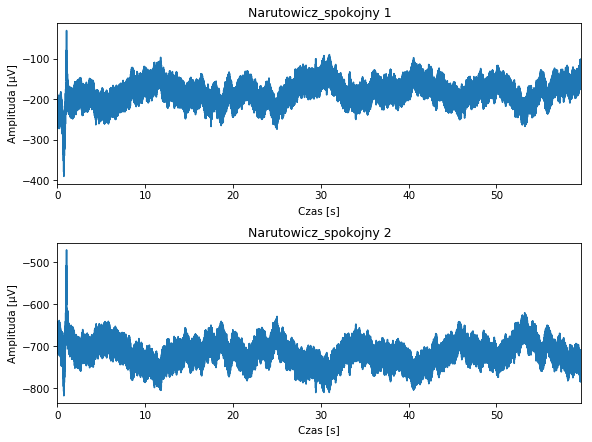

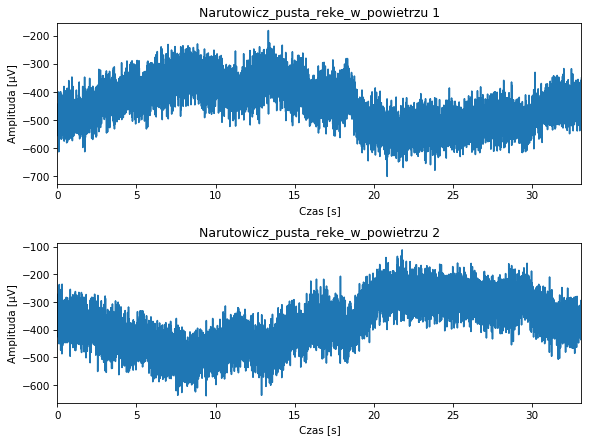

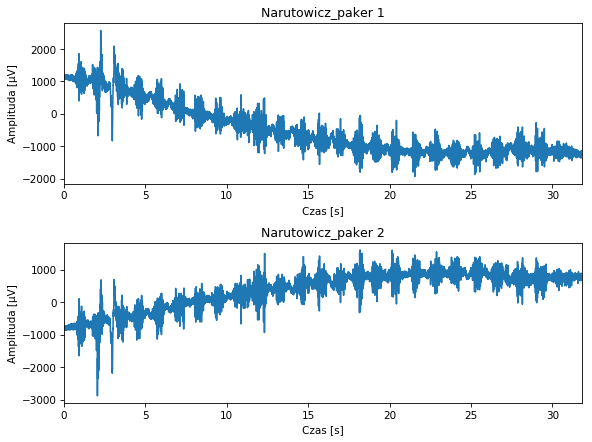

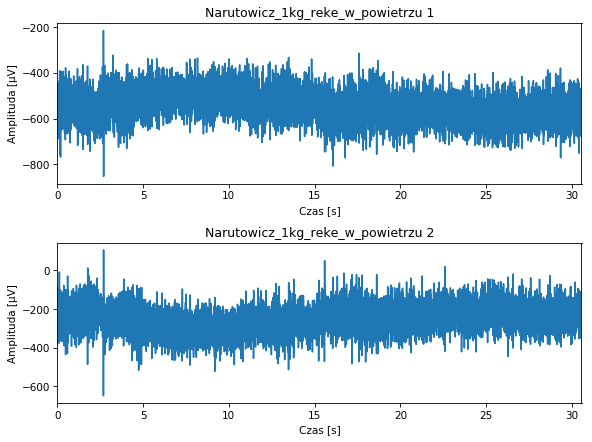

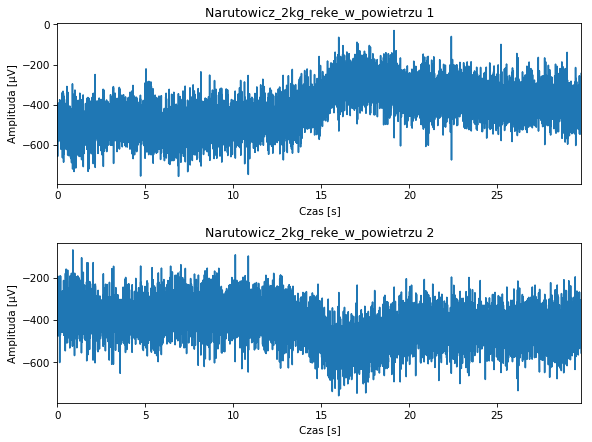

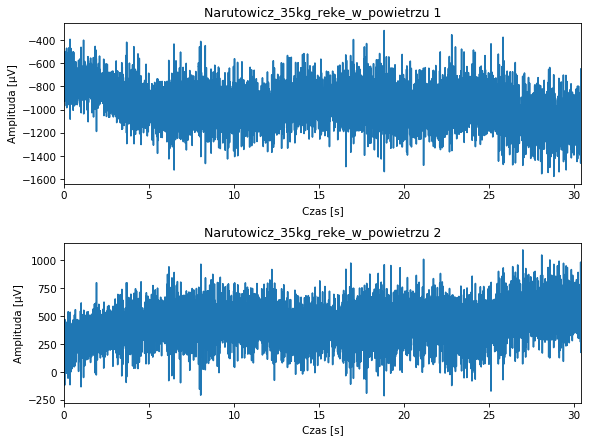

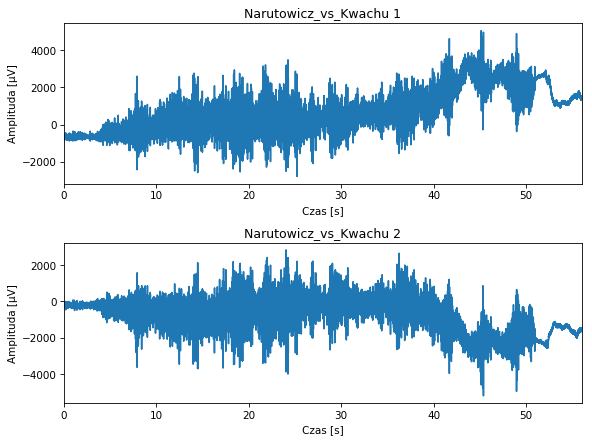

In [127]:
n_ch = 2
Fs = 2048
dt = 1/Fs
calibrationParam = 0.0715 #mikro volty na punkt

nazwaSygnalu = ['data/Narutowicz_spokojny.raw',
                'data/Narutowicz_pusta_reke_w_powietrzu.raw',
                'data/Narutowicz_paker.raw',
                'data/Narutowicz_1kg_reke_w_powietrzu.raw',
                'data/Narutowicz_2kg_reke_w_powietrzu.raw',
                'data/Narutowicz_35kg_reke_w_powietrzu.raw',
                'data/Narutowicz_vs_Kwachu.raw']

signals = list(np.zeros(len(nazwaSygnalu)))
times = list(np.zeros(len(nazwaSygnalu)))
for i,sygnal in enumerate(nazwaSygnalu):
    with open(sygnal, 'rb') as f_out:
        s = np.fromfile(f_out, dtype='float32')
    s_mixed = np.reshape(s,(len(s)//n_ch,n_ch))
    signals[i] = s_mixed * calibrationParam
    times[i] = np.arange(0,len(signals[i])/Fs,dt)
for i in range(len(nazwaSygnalu)):
    plotowanie(times[i],signals[i], n_ch, Fs, title=nazwaSygnalu[i][5:-4]+' ')

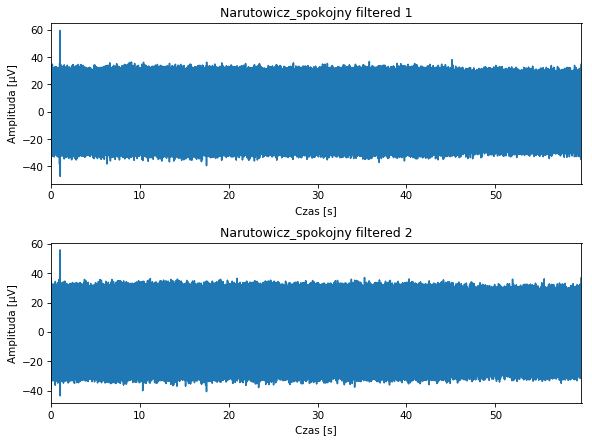

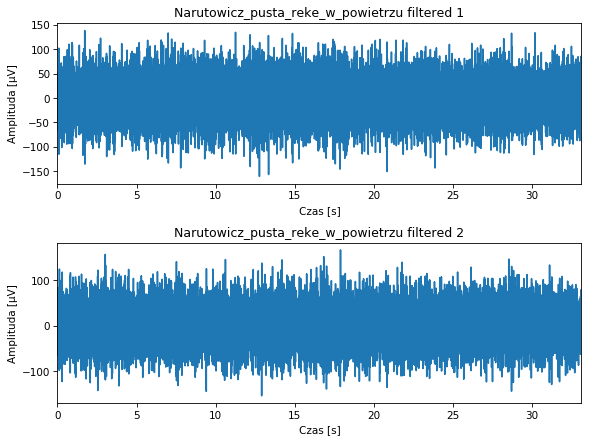

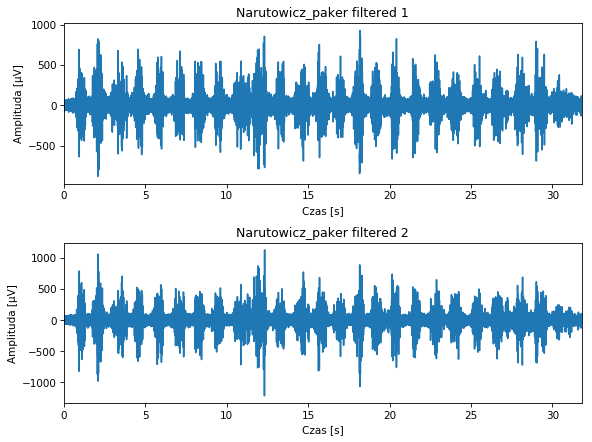

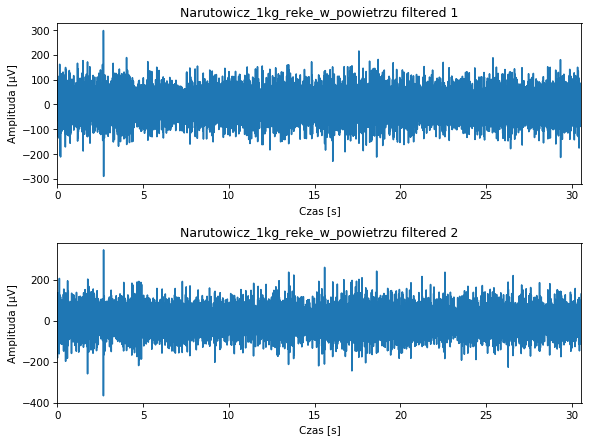

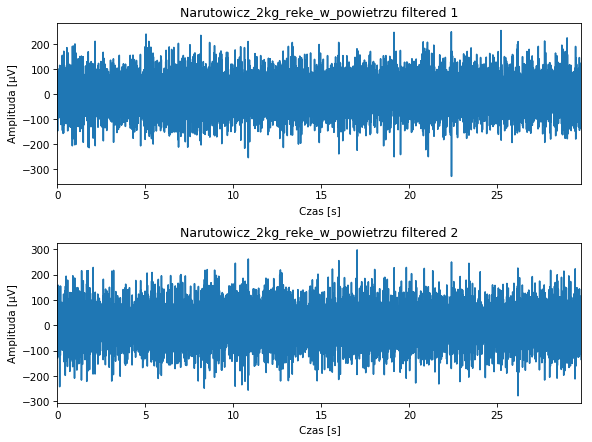

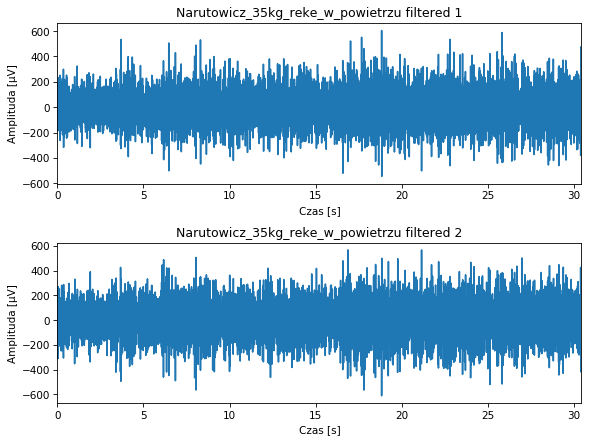

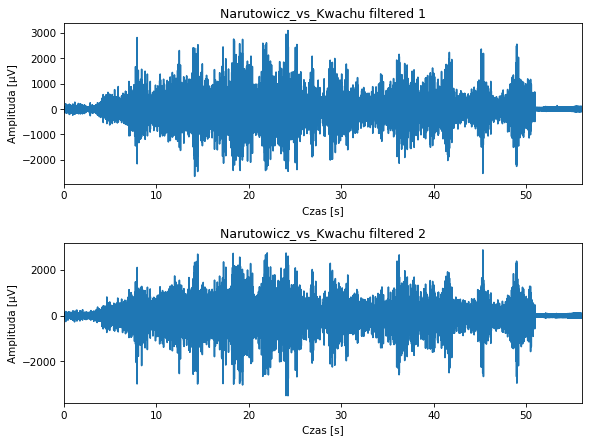

In [128]:
signals_filtered = list(np.zeros(len(nazwaSygnalu)))
for i in range(len(nazwaSygnalu)):
    signals_filtered[i] = np.zeros(signals[i].shape)
    for ch in range(n_ch):
        [b,a] = butter(5, 20/(Fs/2), btype = 'highpass')
        signals_filtered[i][:,ch] = filtfilt(b,a,signals[i][:,ch])
    #     [b,a] = butter(5, np.array([48, 52])/(Fs/2), btype = 'bandstop')
    #     s_mixed_filt[:,ch] = filtfilt(b,a,s_mixed_filt[:,ch])
        [b,a] = butter(5, np.array([148, 152])/(Fs/2), btype = 'bandstop')
        signals_filtered[i][:,ch] = filtfilt(b,a,signals_filtered[i][:,ch])
    plotowanie(times[i], signals_filtered[i],n_ch, Fs, title=nazwaSygnalu[i][5:-4]+' filtered ')

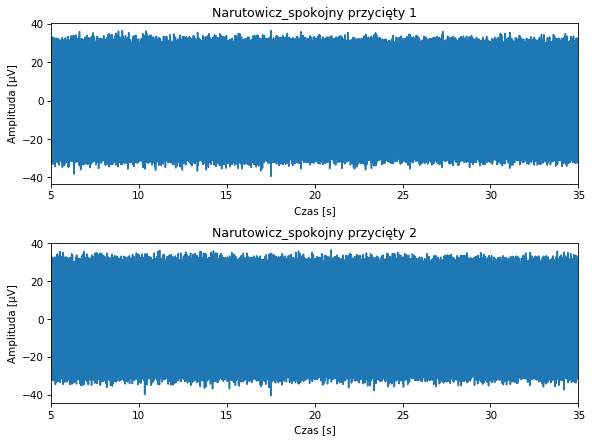

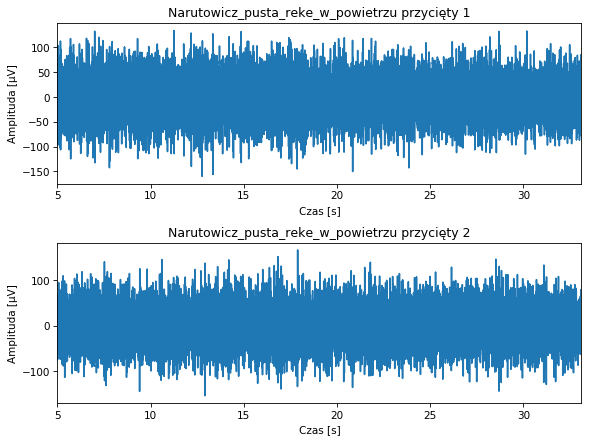

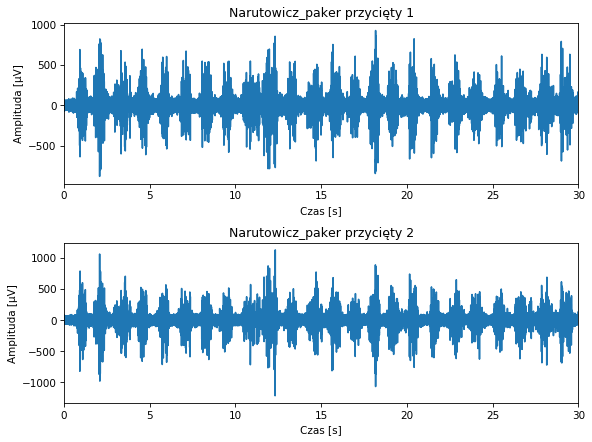

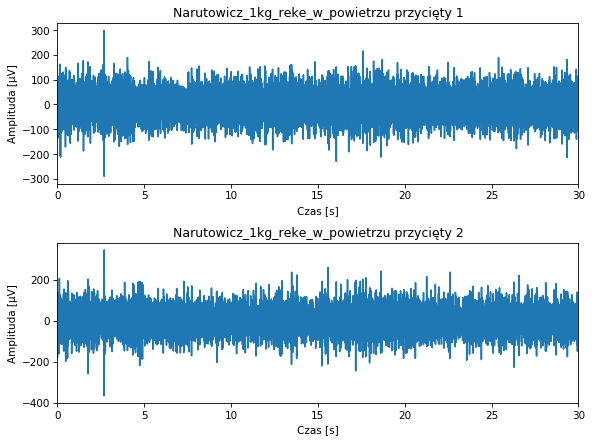

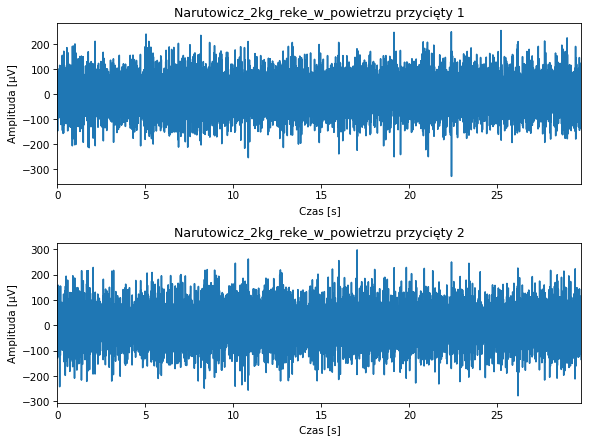

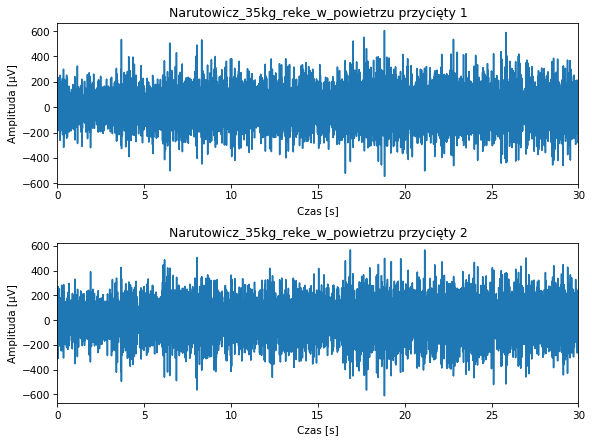

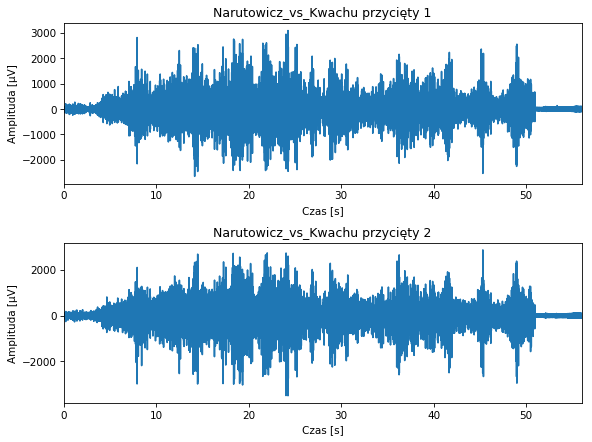

In [131]:
tmin = [5, 5, 0, 0, 0, 0, 0]
tmax = [35, 35, 30, 30, 30, 30, 60]
signal_cutted = list(np.zeros(len(nazwaSygnalu)))
time_cutted = list(np.zeros(len(nazwaSygnalu)))
for i in range(len(nazwaSygnalu)):
    tmin_w_probkach = int(tmin[i] * Fs) #granice czasu
    tmax_w_probkach = int(tmax[i] * Fs)
    t = np.arange(0,len(signals_filtered[i])/Fs,dt)
    time_cutted[i] = t[tmin_w_probkach:tmax_w_probkach]

    signal_cutted[i] = np.zeros([len(time_cutted[i]),n_ch])
    signal_cutted[i][:] = signals_filtered[i][tmin_w_probkach:tmax_w_probkach] #docinamy listę

    plotowanie(time_cutted[i], signal_cutted[i],n_ch, Fs, title=nazwaSygnalu[i][5:-4]+' przycięty ')

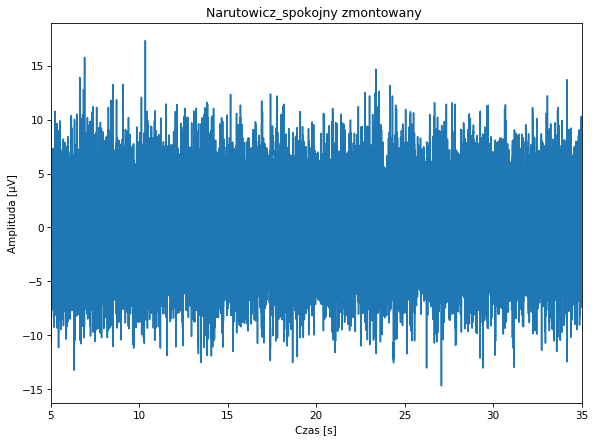

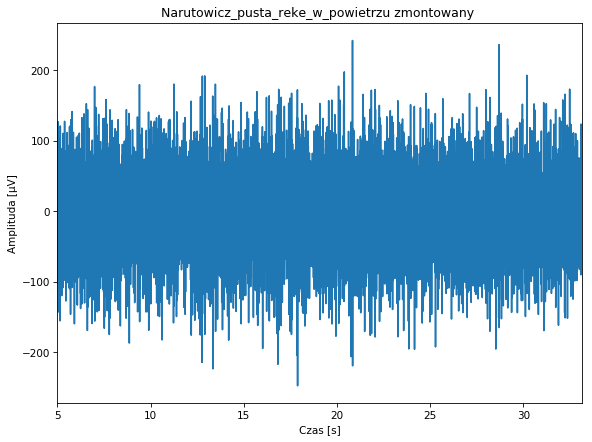

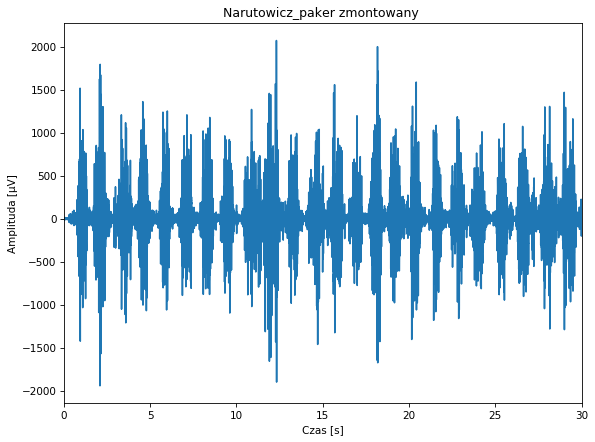

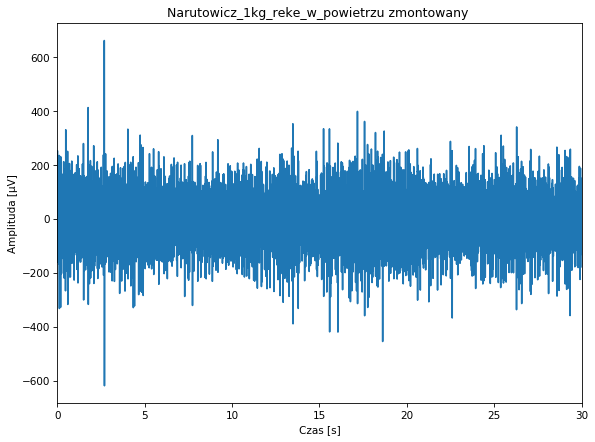

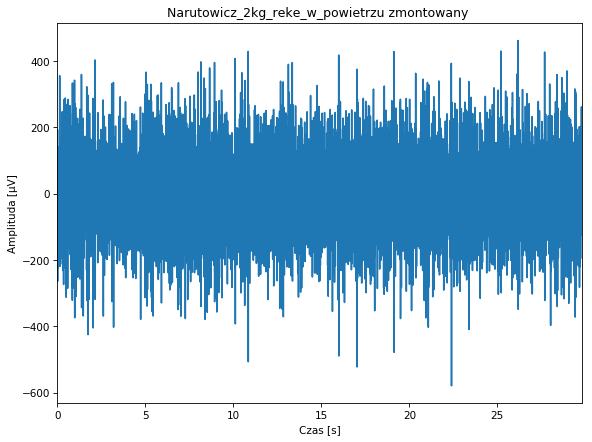

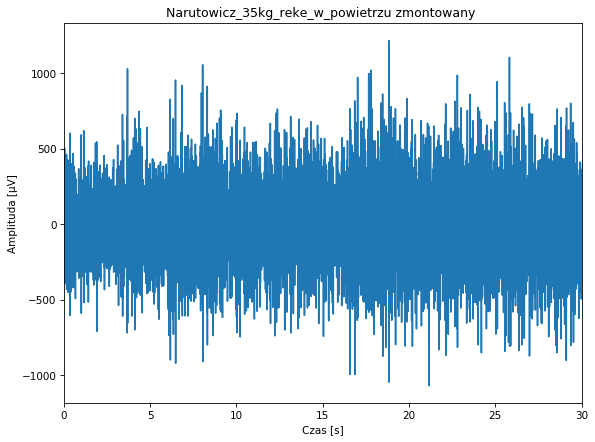

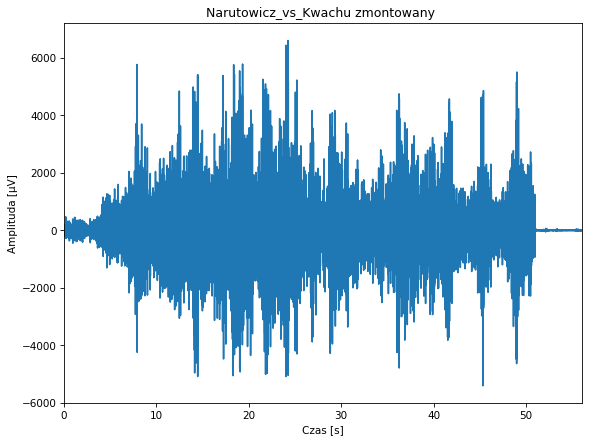

In [132]:
syg = list(np.zeros(len(nazwaSygnalu)))
t_syg = list(np.zeros(len(nazwaSygnalu)))
for i in range(len(nazwaSygnalu)):
    syg[i] = signal_cutted[i][:,0] - signal_cutted[i][:,1]
    t_syg[i] = time_cutted[i]
    plotowanie(t_syg[i], syg[i], ' zmontowany ', Fs, title=nazwaSygnalu[i][5:-4])

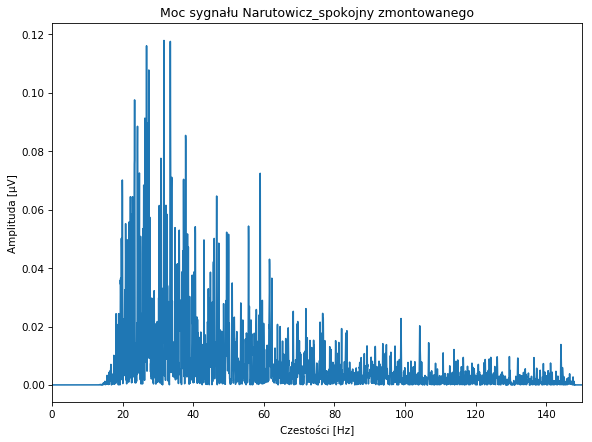

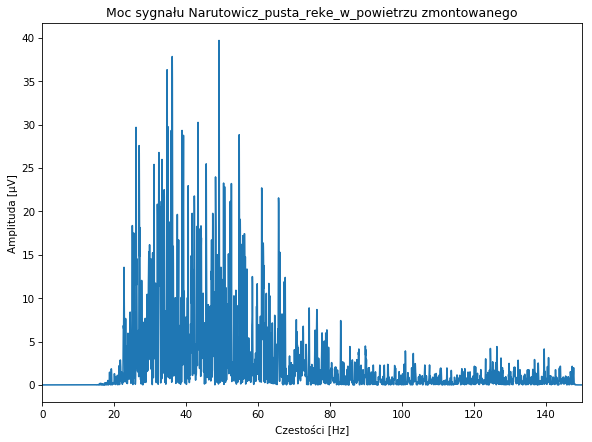

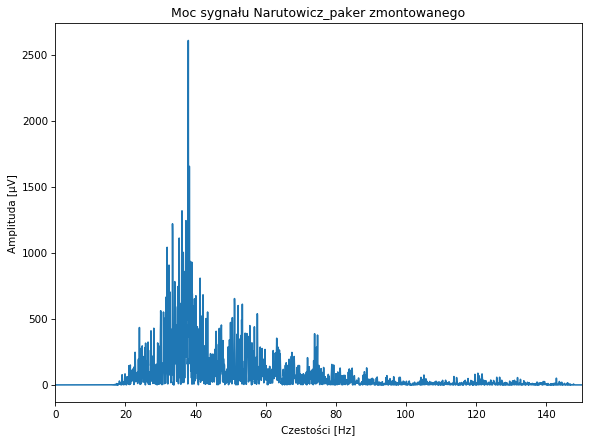

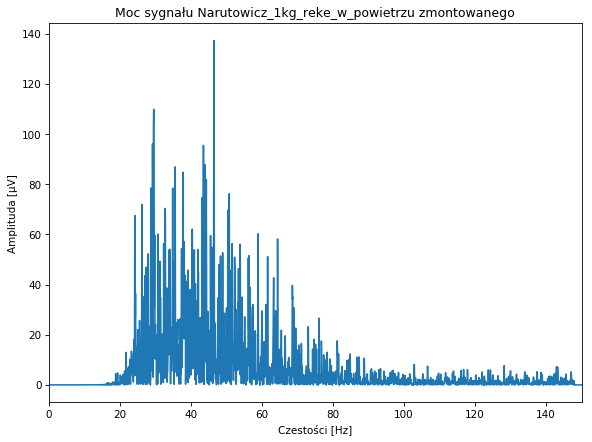

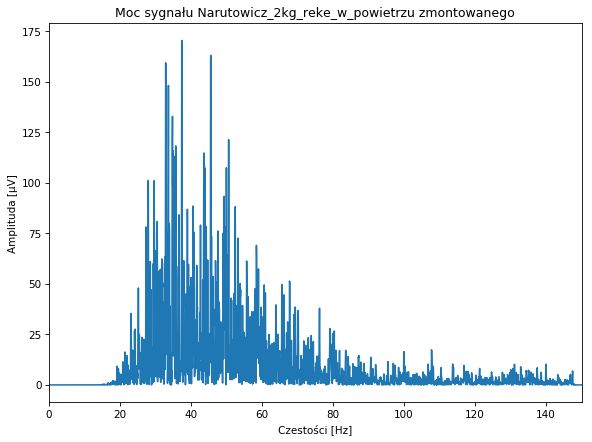

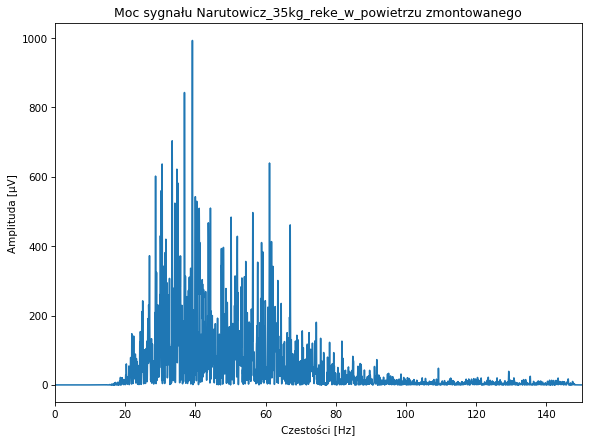

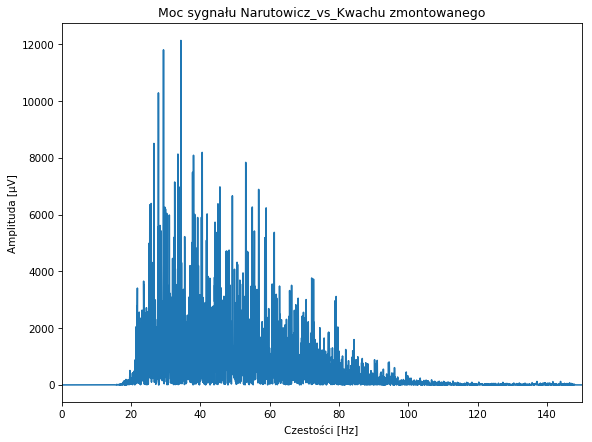

In [133]:
for i in range(len(nazwaSygnalu)):

    Pxx_spec = np.zeros((int(len(syg[i])/2)+1))


    f, Pxx_spec = sg.periodogram(syg[i], Fs, 'flattop', scaling = 'spectrum')

    t = np.arange(0,len(syg[i])/Fs,dt)

    plotowanie(f, Pxx_spec, " zmontowanego", Fs, titlex = 'Czestości [Hz]', title = f'Moc sygnału {nazwaSygnalu[i][5:-4]}', xmax=150)

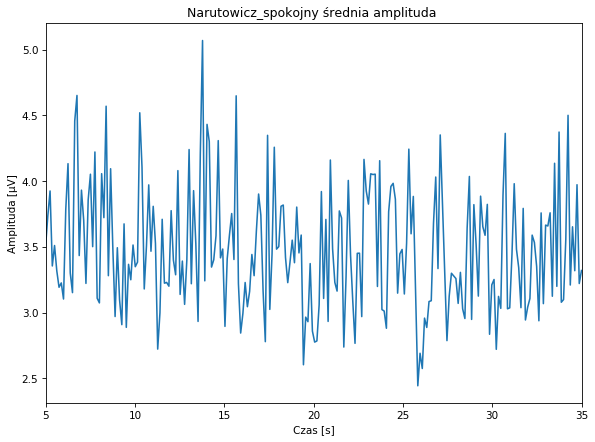

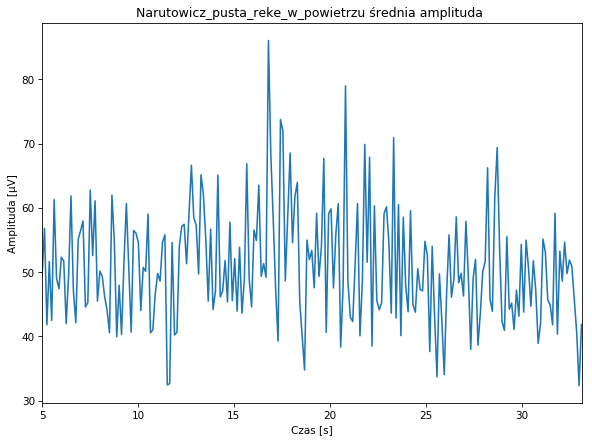

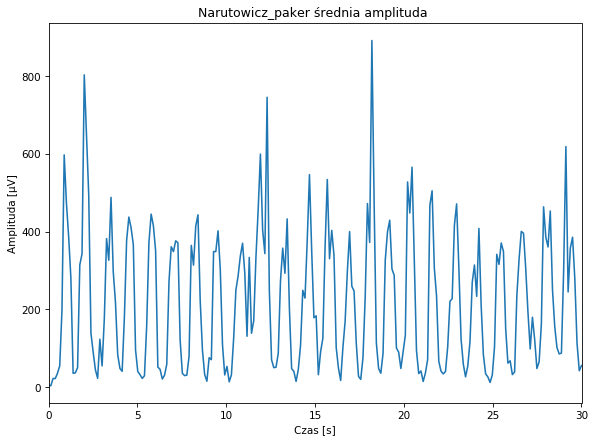

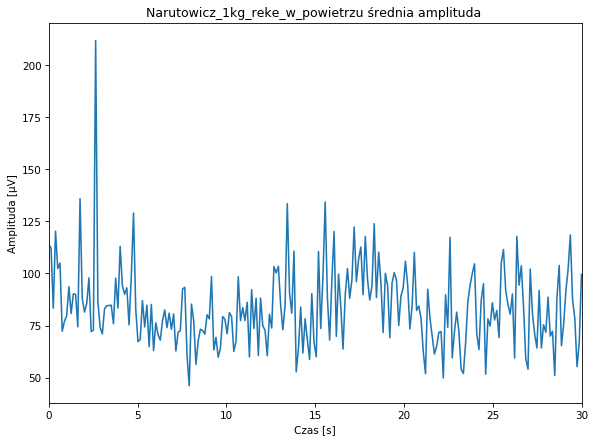

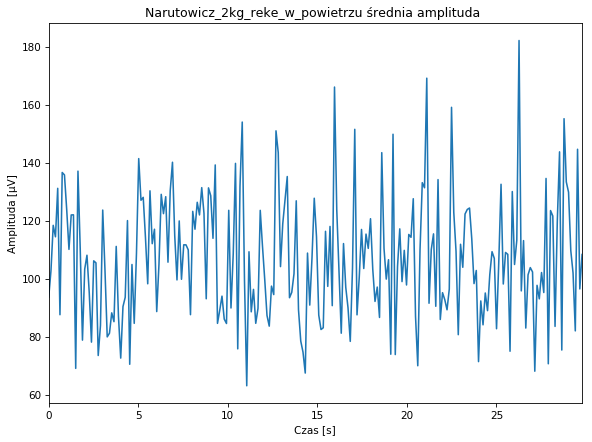

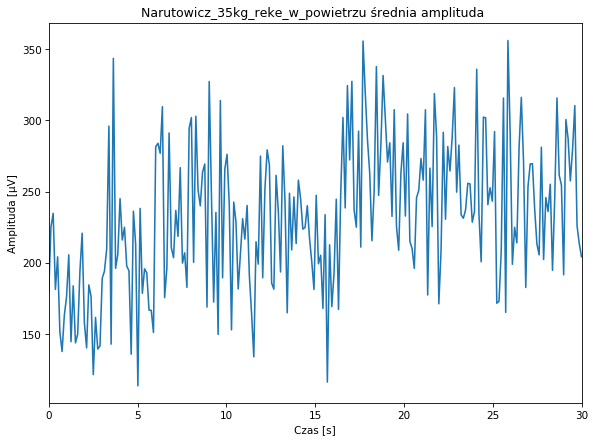

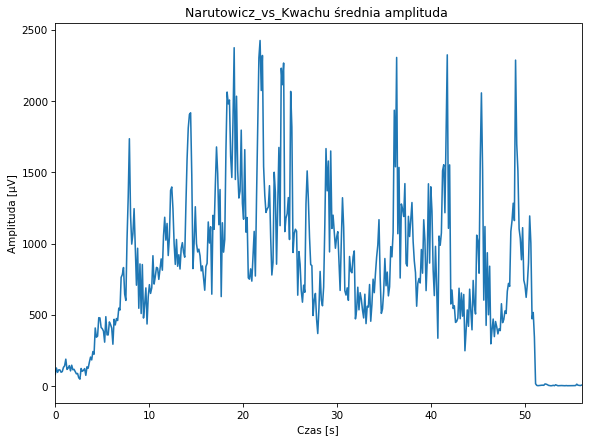

In [134]:
a=3
for index in range(len(nazwaSygnalu)):
    okienko = 0.5**a
    okienko_w_punktach = int(okienko * Fs)
    srednia_amplituda = np.zeros(len(syg[index])//okienko_w_punktach)
    for i, j in zip(list(range(0,len(syg[index]), okienko_w_punktach)), list(range(0,len(srednia_amplituda)))):
        srednia_amplituda[j:j+1] = np.std(syg[index][i:i+okienko_w_punktach])
    t_amplitudy = np.linspace(t_syg[index][0], t_syg[index][-1], len(srednia_amplituda))
    plotowanie(t_amplitudy, srednia_amplituda, ' średnia amplituda ', Fs=1/okienko, title=nazwaSygnalu[index][5:-4])